# Explore Sock Shop Traffic

In [1]:
import json
from pyvis.network import Network
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 24

In [2]:
def get_pod_type(labels):
    pod_type = 'unknown'
    for label in labels:
        if label.startswith('k8s:name='):
            pod_type = label.replace('k8s:name=', '')
            break
        if label.startswith('name='):
            pod_type = label.replace('name=', '')
            break
        if label == 'reserved:world':
            pod_type = 'world'
            break
        if label == 'reserved:kube-apiserver':
            pod_type = 'kube-apiserver'
            break
        if label.startswith('k8s:k8s-app='):
            pod_type = label.replace('k8s:k8s-app=', '')
            break
    
    if pod_type == 'unknown':
        print(labels)
    
    return pod_type

In [3]:
namespace = 'sock-shop'
def create_flow_graph(flows):
    G = nx.DiGraph()

    for f in flows:
        sock_shop_source = False
        sock_shop_dest = False
        if 'namespace' in f['source'] and f['source']['namespace'] == namespace:
            sock_shop_source = True
        if 'namespace' in f['destination'] and f['destination']['namespace'] == namespace:
            sock_shop_dest = True

        # Only collect flows relevant to sockshop
        if sock_shop_source or sock_shop_dest:        
            source_node = get_pod_type(f['source']['labels'])
            dest_node = get_pod_type(f['destination']['labels'])

            if source_node == 'kube-apiserver' or dest_node == 'kube-apiserver':
                continue

            # Add nodes if they dont exist
            if source_node not in G:
                G.add_node(source_node)
            if dest_node not in G:
                G.add_node(dest_node)

            # Add edge if it doesnt exist
            if not G.has_edge(source_node, dest_node):
                G.add_edge(source_node, dest_node, weight=1.)
            else:
                weight = G.get_edge_data(source_node, dest_node)['weight']
                G[source_node][dest_node]['weight'] += 1.
    return G

In [4]:
def read_flows(fname):
    f = open(fname)
    lines = f.readlines()

    flows = []
    for line in lines:
        flows.append(json.loads(line))
        
    return flows

def get_in_out_flows(flow_graph):
    out_flows = {}
    in_flows = {}

    for node in flow_graph:
        out_flows[node] = 0
        in_flows[node] = 0

    for s, d in flow_graph.edges:
        out_flows[s] += flow_graph[s][d]['weight']
        in_flows[d] -= flow_graph[s][d]['weight']
        
    sorted_outflow = {k: v for k, v in sorted(out_flows.items(), key=lambda item: item[0])}
    sorted_inflow = {k: v for k, v in sorted(in_flows.items(), key=lambda item: item[0])}
    return sorted_outflow, sorted_inflow

In [5]:
f = open('../results/baseline_1m.json')
lines = f.readlines()

flows = []
for line in lines:
    flows.append(json.loads(line))

G = create_flow_graph(flows)

nt = Network(height='400px', width='800px', notebook=True, directed=True)
nt.from_nx(G)
nt.toggle_physics(False)
nt.show_buttons(filter_=['physics'])
nt.show('graph.html')

In [6]:
f = open('../results/buy_1m.json')
lines = f.readlines()

flows = []
for line in lines:
    flows.append(json.loads(line))

G = create_flow_graph(flows)

nt = Network(height='800px', width='800px', notebook=True, directed=True)
nt.from_nx(G)
nt.toggle_physics(False)
nt.show_buttons(filter_=['physics'])
nt.show('graph.html')

In [7]:
f = open('../results/buy_1m_high_2.json')
lines = f.readlines()

flows = []
for line in lines:
    flows.append(json.loads(line))

G = create_flow_graph(flows)

nt = Network(height='800px', width='800px', notebook=True, directed=True)

for node in G.nodes:
    nt.add_node(node)
    
for s,d in G.edges:
    nt.add_edge(s,d, title=G[s][d]['weight'], value=G[s][d]['weight'])

nt.toggle_physics(False)
nt.show_buttons(filter_=['physics'])
nt.show('graph.html')

<BarContainer object of 14 artists>

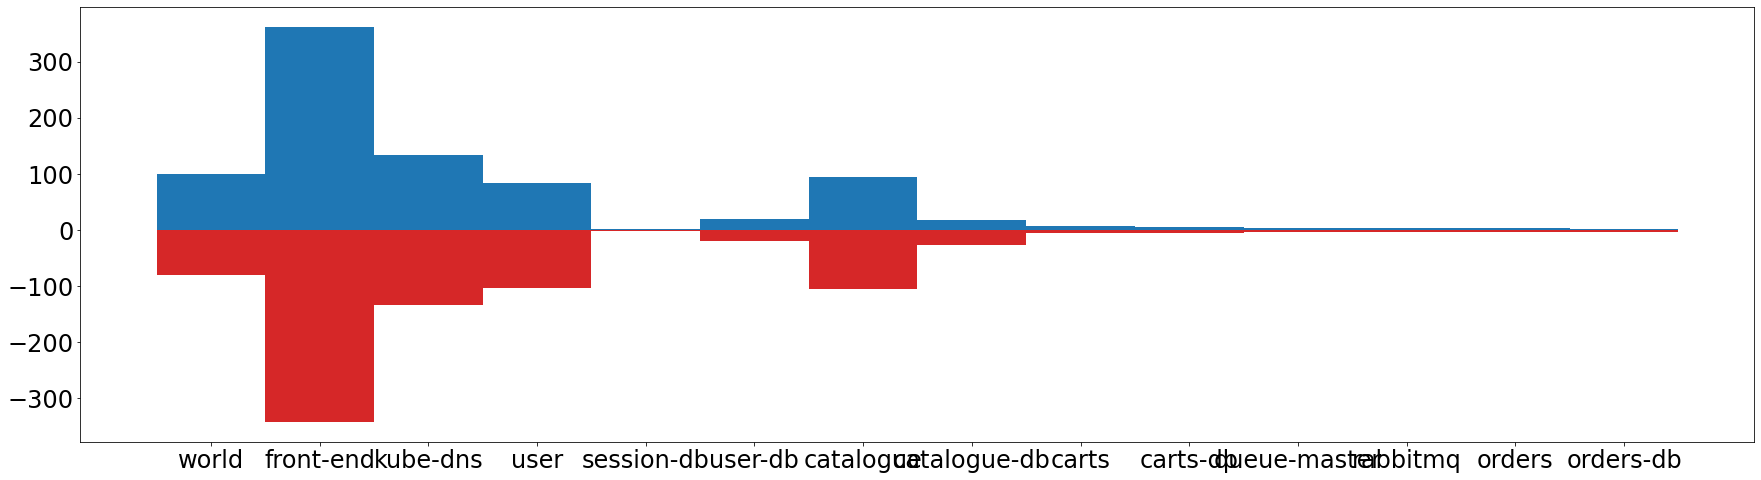

In [8]:
out_flows = {}
in_flows = {}

for node in G:
    out_flows[node] = 0
    in_flows[node] = 0

for s, d in G.edges:
    out_flows[s] += G[s][d]['weight']
    in_flows[d] -= G[s][d]['weight']

fig = plt.figure(figsize=(30,8))
plt.bar(out_flows.keys(), out_flows.values(), width=1, color='tab:blue')
plt.bar(in_flows.keys(), in_flows.values(), width=1, color='tab:red')

FileNotFoundError: [Errno 2] No such file or directory: '../results/register_1m.json'

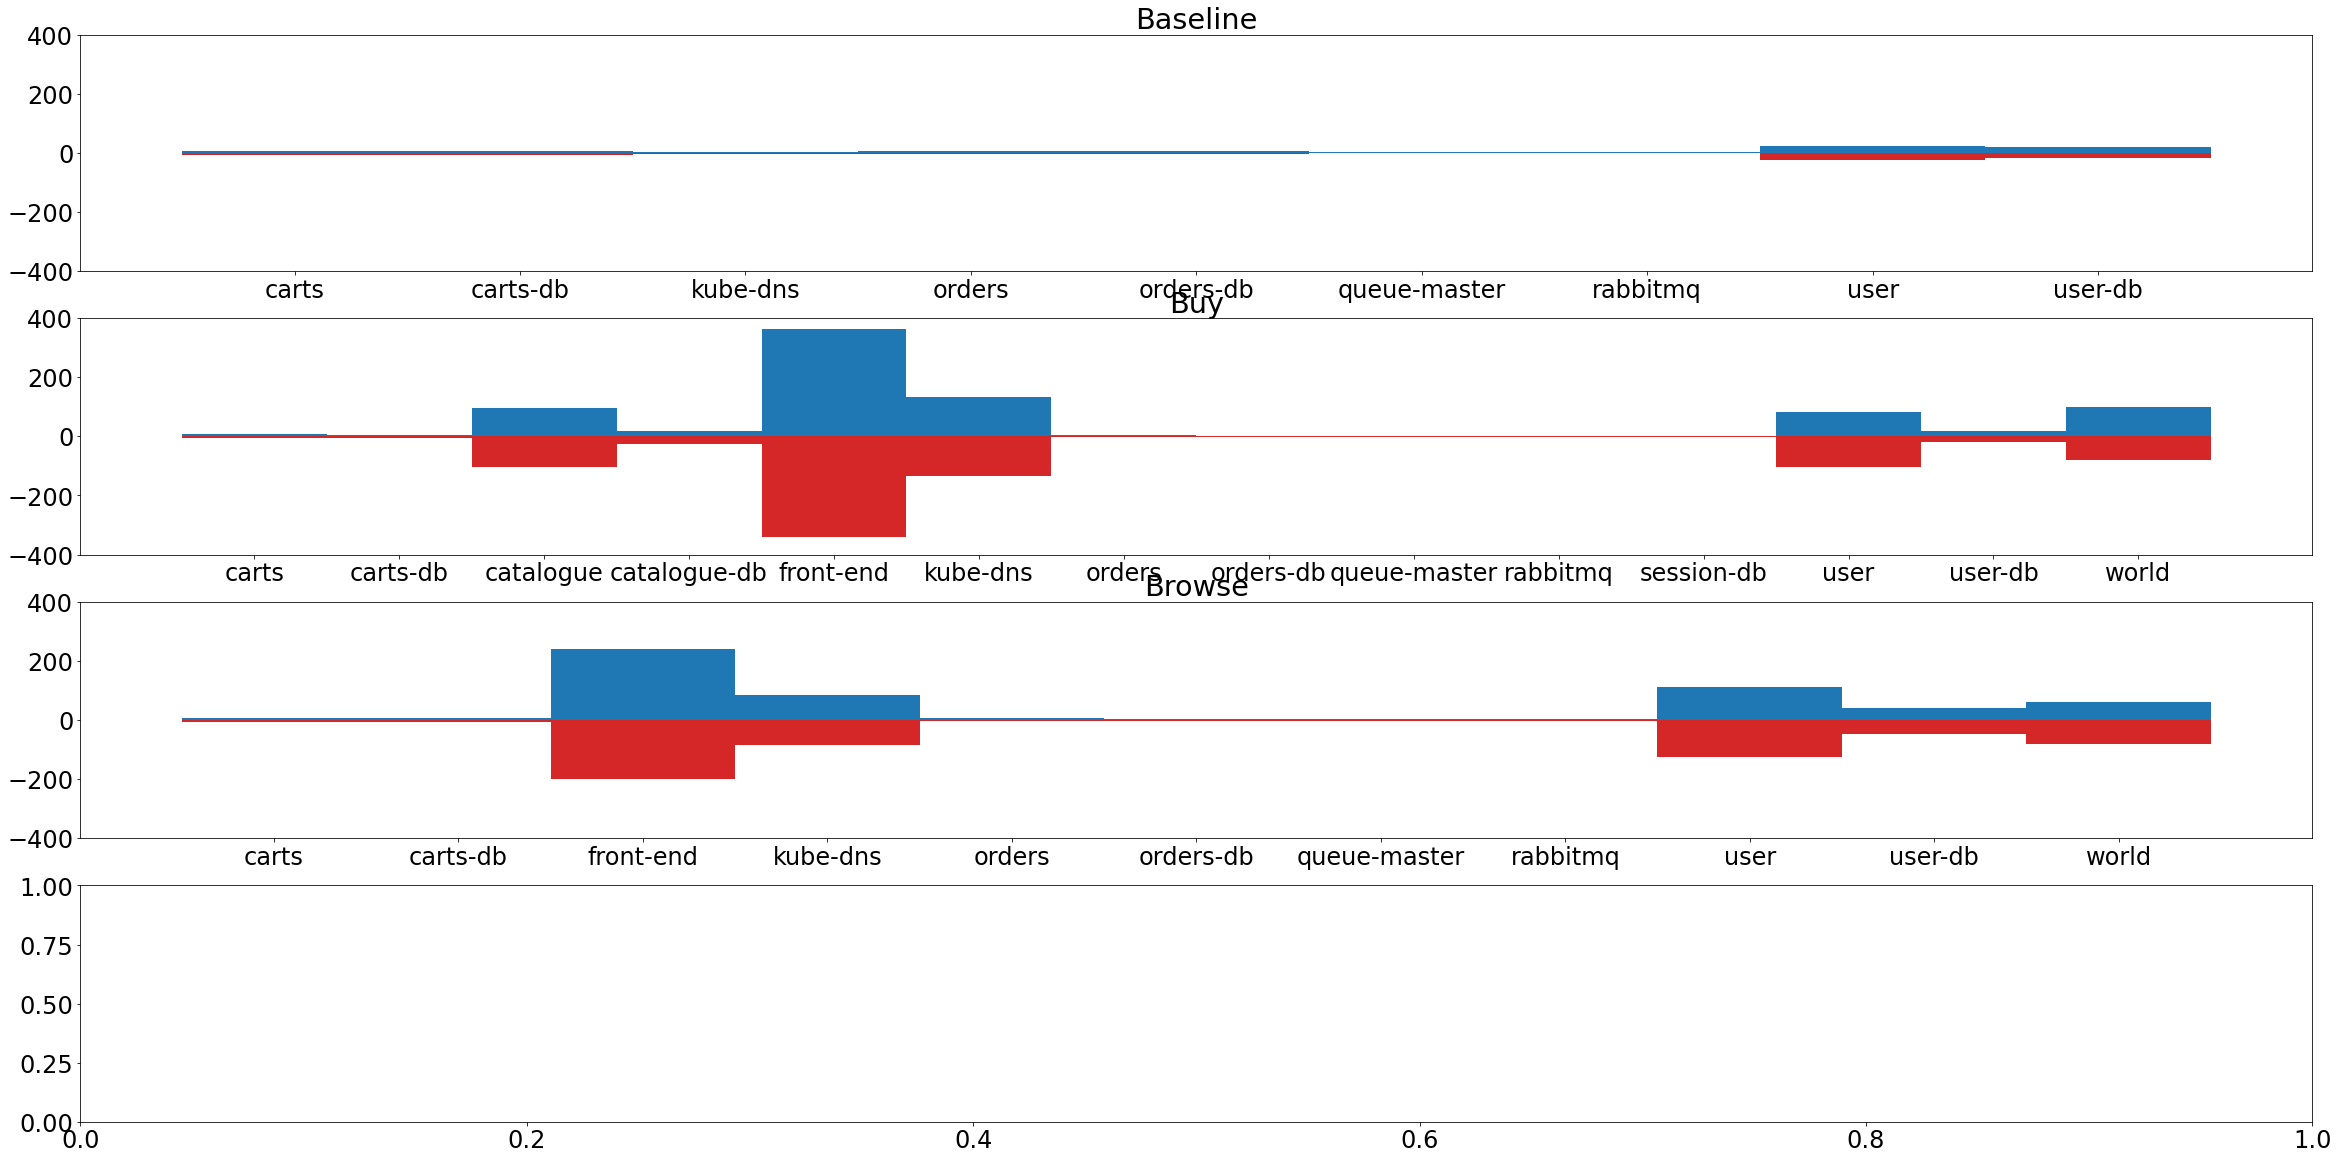

In [9]:
flows = read_flows('../results/baseline_1m.json')
G = create_flow_graph(flows)
out_flows, in_flows = get_in_out_flows(G)

fig, axs = plt.subplots(4, 1, figsize=(40,20))
# fig = plt.figure(figsize=(30,8))

axs[0].set_title('Baseline')
axs[0].bar(out_flows.keys(), out_flows.values(), width=1, color='tab:blue')
axs[0].bar(in_flows.keys(), in_flows.values(), width=1, color='tab:red')
axs[0].set_ylim([-400, 400])

flows = read_flows('../results/buy_1m_high_2.json')
G = create_flow_graph(flows)
out_flows, in_flows = get_in_out_flows(G)

axs[1].set_title('Buy')
axs[1].bar(out_flows.keys(), out_flows.values(), width=1, color='tab:blue')
axs[1].bar(in_flows.keys(), in_flows.values(), width=1, color='tab:red')
axs[1].set_ylim([-400, 400])

flows = read_flows('../results/browse_1m.json')
G = create_flow_graph(flows)
out_flows, in_flows = get_in_out_flows(G)

axs[2].set_title('Browse')
axs[2].bar(out_flows.keys(), out_flows.values(), width=1, color='tab:blue')
axs[2].bar(in_flows.keys(), in_flows.values(), width=1, color='tab:red')
axs[2].set_ylim([-400, 400])


flows = read_flows('../results/register_1m.json')
G = create_flow_graph(flows)
out_flows, in_flows = get_in_out_flows(G)

axs[3].set_title('Register')
axs[3].bar(out_flows.keys(), out_flows.values(), width=1, color='tab:blue')
axs[3].bar(in_flows.keys(), in_flows.values(), width=1, color='tab:red')
axs[3].set_ylim([-400, 400])



In [ ]:
flows = read_flows('../results/buy_1m_high_2.json')
test = create_flow_graph(flows)
out_flows, in_flows = get_in_out_flows(test)
print(in_flows)

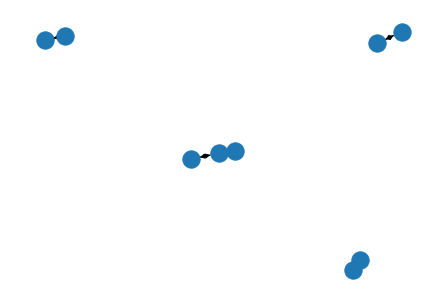

In [16]:
flows = read_flows('../results/baseline_1m.json')
G = create_flow_graph(flows)
out_flows, in_flows = get_in_out_flows(G)

nx.draw(G)

{'world': array([-0.08972222,  0.09750183]), 'front-end': array([-0.05472181,  0.10233126]), 'kube-dns': array([-0.02395998,  0.11912999]), 'user': array([-0.04927015,  0.15405601]), 'session-db': array([-0.22873324,  0.03905155]), 'user-db': array([-0.03138953,  0.21999533]), 'catalogue': array([-0.04543615,  0.04767465]), 'catalogue-db': array([-0.03929284, -0.02244394]), 'carts': array([-0.17679444,  0.38952093]), 'carts-db': array([-0.22926008,  0.47957124]), 'queue-master': array([ 0.16773955, -0.97532918]), 'rabbitmq': array([ 0.08757537, -1.        ]), 'orders': array([0.28342077, 0.16302271]), 'orders-db': array([0.42984476, 0.18591761])}


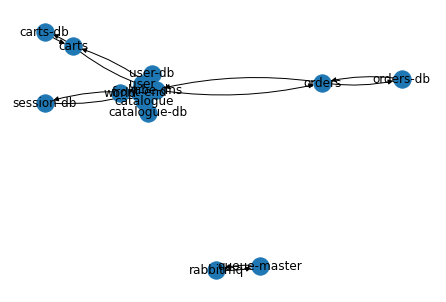

In [25]:
flows = read_flows('../results/buy_1m_high_2.json')
G = create_flow_graph(flows)
out_flows, in_flows = get_in_out_flows(test)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, connectionstyle='arc3, rad = 0.1')
print(pos)